In [1]:
import numpy as np
import pandas as pd

In [3]:
df = pd.read_csv("train_data.csv")
raw_data = pd.read_csv("train_data.csv")

In [5]:
df.head()

,client_id,cato_code,gender,country,citizenship,age_days,client_days,opsos_code,phone_digits,max_dup,...,salary_10,transfers_amount_in_8,transfers_count_in_8,transfers_amount_out_8,transfers_count_out_8,transactions_amount_8,transactions_count_8,auth_count_8,salary_8,label
0,2152686,17.0,1.0,0.0,0.0,11643.0,130.0,9.0,5.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1712777,2.0,NaN,0.0,0.0,18095.0,994.0,5.0,5.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,458915,NaN,0.0,0.0,0.0,7955.0,1144.0,7.0,5.0,1.0,...,NaN,NaN,NaN,NaN,NaN,0.037251,0.033580,0.03358,NaN,0
3,530220,NaN,0.0,0.0,0.0,22580.0,847.0,0.0,6.0,1.0,...,0.03656,NaN,NaN,NaN,NaN,0.115086,0.033581,0.03358,0.092161,0
4,1103654,12.0,0.0,0.0,0.0,13107.0,547.0,12.0,6.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [4]:
# finding features with all NAN values
drop_features = list(df.loc[:,((df.isnull().sum()/df.shape[0])==1).values].columns)
drop_features

['transactions_amount_9',
 'transactions_count_9',
 'transactions_amount_10',
 'transactions_count_10',
 'transfers_amount_in_8',
 'transfers_count_in_8',
 'transfers_amount_out_8',
 'transfers_count_out_8']

In [6]:
df.columns

Index(['client_id', 'cato_code', 'gender', 'country', 'citizenship',
       'age_days', 'client_days', 'opsos_code', 'phone_digits', 'max_dup',
       'monthly_installment', 'date_close', 'deposit_sum_KZT',
       'deposit_sum_USD', 'deposit_sum_EUR', 'deal_sum_kzt_express',
       'expired_day_express', 'deal_start_date_express',
       'plan_end_date_express', 'deal_sum_kzt_product', 'expired_day_product',
       'deal_start_date_product', 'plan_end_date_product',
       'transfers_amount_in_9', 'transfers_count_in_9',
       'transfers_amount_out_9', 'transfers_count_out_9',
       'transactions_amount_9', 'transactions_count_9', 'auth_count_9',
       'salary_9', 'transfers_amount_in_10', 'transfers_count_in_10',
       'transfers_amount_out_10', 'transfers_count_out_10',
       'transactions_amount_10', 'transactions_count_10', 'auth_count_10',
       'salary_10', 'transfers_amount_in_8', 'transfers_count_in_8',
       'transfers_amount_out_8', 'transfers_count_out_8',
       'tra

# Feature engineering

In [7]:
def drop_cols(df):
    drop_features = list(df.loc[:,((df.isnull().sum()/df.shape[0])==1).values].columns)
    df.drop(drop_features, axis=1, inplace=True)
    return df

In [8]:
def fill_cols(df):
    fill_features_0 = ['deposit_sum_KZT', 'deposit_sum_USD', 'deposit_sum_EUR']
    df[fill_features_0] = df[fill_features_0].fillna(0, axis=1)
    feature_fill = ['transfers_amount_in_9', 'transfers_count_in_9', 'transfers_amount_out_9', 'transfers_count_out_9', 'transfers_amount_in_10', 'transfers_count_in_10', 'transfers_amount_out_10', 'transfers_count_out_10', 'transactions_amount_8', 'transactions_count_8', 'auth_count_9', 'auth_count_10', 'auth_count_8']
    for feature in feature_fill:
        df[feature].fillna(df[feature].mean(), inplace=True)
    return df

In [9]:
def mean_salary(df):
    salary_list = ['salary_8', 'salary_9', 'salary_10']
    df[salary_list] = df[salary_list].fillna(0, axis=1)
    df['mean_salary'] = df[salary_list].sum(axis=1)
    df['mean_salary'] = df['mean_salary'] / 3
    df.drop(salary_list, axis=1, inplace=True)
    
    extreme_low = 0
    low = df[df.mean_salary>0]['mean_salary'].describe()[4]
    medium = df[df.mean_salary>0]['mean_salary'].describe()[5]
    high = df[df.mean_salary>0]['mean_salary'].describe()[6]
    extreme_high = df[df.mean_salary>0]['mean_salary'].describe()[7]

    salaries = [0, 1, 2, 3, 4]
    df.loc[df['mean_salary'] == extreme_low, 'salary_groups'] = salaries[0]
    df.loc[df['mean_salary'] > extreme_low, 'salary_groups'] = salaries[1]
    df.loc[df['mean_salary'] > low, 'salary_groups'] = salaries[2]
    df.loc[df['mean_salary'] > medium, 'salary_groups'] = salaries[3]
    df.loc[df['mean_salary'] > high, 'salary_groups'] = salaries[4]
    
    return df

In [10]:
def deposit(df):
    # Filling deposit columns with 0
    fill_features_0 = ['deposit_sum_KZT', 'deposit_sum_USD', 'deposit_sum_EUR']
    df[fill_features_0] = df[fill_features_0].fillna(0, axis=1)
    # Adding 3 new columns for each group
    df['no_deposit'] = 0
    df['closed_deposit'] = 0
    df['not_closed_deposit'] = 0
    # Filling 
    df.loc[df[fill_features_0].sum(axis=1) > 0 , 'not_closed_deposit'] = 1
    df.loc[pd.notnull(df['date_close']), 'closed_deposit'] = 1
    df.loc[((df[fill_features_0].sum(axis=1) == 0)  & (pd.isnull(df['date_close']))), 'no_deposit'] = 1
    #df.loc[pd.isnull(df['date_close']), 'no_deposit'] = 1
    # Dropping initial deposit columns
    df.drop(fill_features_0, axis=1, inplace=True)
    return df

In [11]:
def desired_added(df):
    not_closed_deposit_index = df.loc[df['not_closed_deposit'] == 1, 'client_id'].tolist()
    salary_X_index = df.loc[df['mean_salary'] > 0, 'client_id'].tolist()
    shared_user = list(set(not_closed_deposit_index).intersection(salary_X_index))
    df['desired_user'] = 0
    df.loc[df['client_id'].isin(shared_user), 'desired_user'] = 1
    return df

In [12]:
def date_to_num(col):
    col = pd.to_datetime(col)
    c = list()
    for row in col:
        if pd.isnull(row.year):
            c.append(0)
        elif row.year < 2021:
            c.append(1)
        elif row.year >= 2021 and row.year <= 2023:
            c.append(2)
        else:
            c.append(3)
    return c

In [13]:
import datetime 

def dates(df):
    df['dsde'] = date_to_num(df['deal_start_date_express'])
    df['pede'] = date_to_num(df['plan_end_date_express'])
    df['pedp'] = date_to_num(df['plan_end_date_product'])
    df['dsdp'] = date_to_num(df['deal_start_date_product'])
    df['dc'] = date_to_num(df['date_close'])
    
    date = ['deal_start_date_express', 'plan_end_date_express', 'plan_end_date_product', 'deal_start_date_product', 'date_close']
    for time in date:
        df[time] = pd.to_datetime(df[time])
        df[time] = df[time].map(datetime.datetime.toordinal)
    return df

In [14]:
df = raw_data.copy()
df = drop_cols(df)
df = fill_cols(df)
df = mean_salary(df)
df = deposit(df)
df = desired_added(df)
df = dates(df)

In [15]:
df.head()

,client_id,cato_code,gender,country,citizenship,age_days,client_days,opsos_code,phone_digits,max_dup,...,salary_groups,no_deposit,closed_deposit,not_closed_deposit,desired_user,dsde,pede,pedp,dsdp,dc
0,2152686,17.0,1.0,0.0,0.0,11643.0,130.0,9.0,5.0,1.0,...,0.0,1,0,0,0,0,0,0,0,0
1,1712777,2.0,NaN,0.0,0.0,18095.0,994.0,5.0,5.0,1.0,...,0.0,1,0,0,0,0,0,0,0,0
2,458915,NaN,0.0,0.0,0.0,7955.0,1144.0,7.0,5.0,1.0,...,0.0,0,1,0,0,0,0,0,0,2
3,530220,NaN,0.0,0.0,0.0,22580.0,847.0,0.0,6.0,1.0,...,3.0,1,0,0,0,0,0,0,0,0
4,1103654,12.0,0.0,0.0,0.0,13107.0,547.0,12.0,6.0,1.0,...,0.0,1,0,0,0,0,0,0,0,0


<AxesSubplot:>

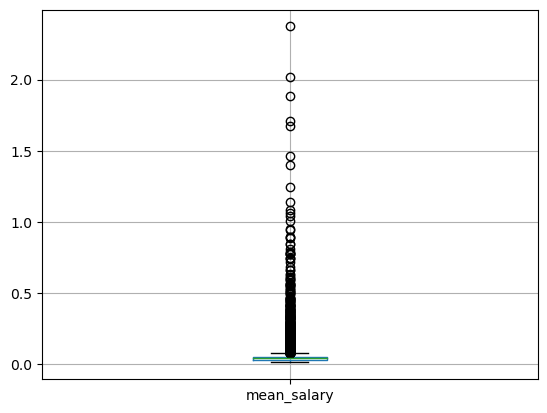

In [16]:
df[df.mean_salary>0].boxplot(['mean_salary'])

In [17]:
df.corr().label.sort_values(ascending=False)

label                      1.000000
pedp                       0.253926
dsdp                       0.239066
plan_end_date_product      0.239066
deal_start_date_product    0.239040
auth_count_10              0.149568
auth_count_9               0.134895
transfers_count_out_10     0.098091
auth_count_8               0.093687
deal_sum_kzt_product       0.087642
expired_day_product        0.085945
transfers_count_out_9      0.080508
transactions_count_8       0.076190
transfers_count_in_10      0.053779
dsde                       0.047748
transfers_count_in_9       0.044070
deal_start_date_express    0.042635
plan_end_date_express      0.042615
desired_user               0.040845
pede                       0.040512
mean_salary                0.031165
not_closed_deposit         0.022793
salary_groups              0.022730
expired_day_express        0.015317
max_dup                    0.014001
transactions_amount_8      0.011291
transfers_amount_in_10     0.011235
transfers_amount_out_10    0

In [18]:
features = abs(df.corr().label.sort_values(ascending=False))[1:9].index

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df[features], df.label, random_state=31, train_size=0.8)

In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [21]:
from xgboost import XGBClassifier

model = XGBClassifier()
model.fit(X_train_scaled, y_train.values.ravel()) 

# Predict the Test set results
y_pred = model.predict(X_test_scaled)

C:\Users\user\miniconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\user\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:00:52] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [24]:
from catboost import CatBoostClassifier

cat_features = list(range(0, X_train_scaled.shape[1]))

clf = CatBoostClassifier()
clf.fit(X_train_scaled, y_train.values.ravel())

Learning rate set to 0.174333
0:	learn: 0.3350239	total: 333ms	remaining: 5m 32s
1:	learn: 0.1938673	total: 503ms	remaining: 4m 11s
2:	learn: 0.1189794	total: 663ms	remaining: 3m 40s
3:	learn: 0.0844487	total: 815ms	remaining: 3m 22s
4:	learn: 0.0673083	total: 975ms	remaining: 3m 14s
5:	learn: 0.0581442	total: 1.14s	remaining: 3m 8s
6:	learn: 0.0529171	total: 1.32s	remaining: 3m 7s
7:	learn: 0.0498010	total: 1.48s	remaining: 3m 3s
8:	learn: 0.0480430	total: 1.65s	remaining: 3m 1s
9:	learn: 0.0466848	total: 1.82s	remaining: 2m 59s
10:	learn: 0.0458026	total: 1.94s	remaining: 2m 54s
11:	learn: 0.0451521	total: 2.05s	remaining: 2m 48s
12:	learn: 0.0446164	total: 2.18s	remaining: 2m 45s
13:	learn: 0.0442905	total: 2.32s	remaining: 2m 43s
14:	learn: 0.0440424	total: 2.46s	remaining: 2m 41s
15:	learn: 0.0438091	total: 2.58s	remaining: 2m 38s
16:	learn: 0.0436253	total: 2.71s	remaining: 2m 36s
17:	learn: 0.0434827	total: 2.85s	remaining: 2m 35s
18:	learn: 0.0433403	total: 2.97s	remaining: 2m 

160:	learn: 0.0401105	total: 19.1s	remaining: 1m 39s
161:	learn: 0.0400969	total: 19.2s	remaining: 1m 39s
162:	learn: 0.0400879	total: 19.3s	remaining: 1m 39s
163:	learn: 0.0400796	total: 19.4s	remaining: 1m 38s
164:	learn: 0.0400655	total: 19.5s	remaining: 1m 38s
165:	learn: 0.0400520	total: 19.6s	remaining: 1m 38s
166:	learn: 0.0400401	total: 19.7s	remaining: 1m 38s
167:	learn: 0.0400323	total: 19.8s	remaining: 1m 38s
168:	learn: 0.0400174	total: 19.9s	remaining: 1m 37s
169:	learn: 0.0400077	total: 20s	remaining: 1m 37s
170:	learn: 0.0399949	total: 20.2s	remaining: 1m 37s
171:	learn: 0.0399884	total: 20.3s	remaining: 1m 37s
172:	learn: 0.0399779	total: 20.4s	remaining: 1m 37s
173:	learn: 0.0399621	total: 20.5s	remaining: 1m 37s
174:	learn: 0.0399520	total: 20.6s	remaining: 1m 37s
175:	learn: 0.0399434	total: 20.7s	remaining: 1m 37s
176:	learn: 0.0399383	total: 20.9s	remaining: 1m 36s
177:	learn: 0.0399350	total: 21s	remaining: 1m 36s
178:	learn: 0.0399258	total: 21.1s	remaining: 1m 3

317:	learn: 0.0389528	total: 36.4s	remaining: 1m 18s
318:	learn: 0.0389444	total: 36.5s	remaining: 1m 17s
319:	learn: 0.0389354	total: 36.6s	remaining: 1m 17s
320:	learn: 0.0389280	total: 36.7s	remaining: 1m 17s
321:	learn: 0.0389199	total: 36.9s	remaining: 1m 17s
322:	learn: 0.0389131	total: 37s	remaining: 1m 17s
323:	learn: 0.0389057	total: 37.1s	remaining: 1m 17s
324:	learn: 0.0388957	total: 37.2s	remaining: 1m 17s
325:	learn: 0.0388812	total: 37.4s	remaining: 1m 17s
326:	learn: 0.0388748	total: 37.5s	remaining: 1m 17s
327:	learn: 0.0388623	total: 37.7s	remaining: 1m 17s
328:	learn: 0.0388576	total: 37.8s	remaining: 1m 17s
329:	learn: 0.0388540	total: 37.9s	remaining: 1m 16s
330:	learn: 0.0388514	total: 38s	remaining: 1m 16s
331:	learn: 0.0388498	total: 38.1s	remaining: 1m 16s
332:	learn: 0.0388455	total: 38.3s	remaining: 1m 16s
333:	learn: 0.0388316	total: 38.4s	remaining: 1m 16s
334:	learn: 0.0388237	total: 38.5s	remaining: 1m 16s
335:	learn: 0.0388167	total: 38.7s	remaining: 1m 1

475:	learn: 0.0380466	total: 54.9s	remaining: 1m
476:	learn: 0.0380346	total: 55s	remaining: 1m
477:	learn: 0.0380310	total: 55.1s	remaining: 1m
478:	learn: 0.0380242	total: 55.2s	remaining: 1m
479:	learn: 0.0380196	total: 55.4s	remaining: 60s
480:	learn: 0.0380157	total: 55.5s	remaining: 59.8s
481:	learn: 0.0380121	total: 55.6s	remaining: 59.7s
482:	learn: 0.0380071	total: 55.7s	remaining: 59.6s
483:	learn: 0.0380024	total: 55.8s	remaining: 59.5s
484:	learn: 0.0379942	total: 55.9s	remaining: 59.3s
485:	learn: 0.0379872	total: 56s	remaining: 59.2s
486:	learn: 0.0379810	total: 56.1s	remaining: 59.1s
487:	learn: 0.0379741	total: 56.2s	remaining: 58.9s
488:	learn: 0.0379675	total: 56.3s	remaining: 58.8s
489:	learn: 0.0379591	total: 56.4s	remaining: 58.7s
490:	learn: 0.0379527	total: 56.5s	remaining: 58.5s
491:	learn: 0.0379489	total: 56.6s	remaining: 58.4s
492:	learn: 0.0379426	total: 56.7s	remaining: 58.3s
493:	learn: 0.0379373	total: 56.8s	remaining: 58.2s
494:	learn: 0.0379308	total: 5

635:	learn: 0.0372375	total: 1m 11s	remaining: 40.8s
636:	learn: 0.0372366	total: 1m 11s	remaining: 40.7s
637:	learn: 0.0372323	total: 1m 11s	remaining: 40.6s
638:	learn: 0.0372276	total: 1m 11s	remaining: 40.5s
639:	learn: 0.0372231	total: 1m 11s	remaining: 40.4s
640:	learn: 0.0372188	total: 1m 11s	remaining: 40.2s
641:	learn: 0.0372141	total: 1m 11s	remaining: 40.1s
642:	learn: 0.0372077	total: 1m 12s	remaining: 40s
643:	learn: 0.0372018	total: 1m 12s	remaining: 39.9s
644:	learn: 0.0371985	total: 1m 12s	remaining: 39.8s
645:	learn: 0.0371926	total: 1m 12s	remaining: 39.6s
646:	learn: 0.0371838	total: 1m 12s	remaining: 39.5s
647:	learn: 0.0371778	total: 1m 12s	remaining: 39.4s
648:	learn: 0.0371730	total: 1m 12s	remaining: 39.3s
649:	learn: 0.0371648	total: 1m 12s	remaining: 39.2s
650:	learn: 0.0371608	total: 1m 12s	remaining: 39.1s
651:	learn: 0.0371575	total: 1m 12s	remaining: 39s
652:	learn: 0.0371526	total: 1m 13s	remaining: 38.8s
653:	learn: 0.0371474	total: 1m 13s	remaining: 38.

792:	learn: 0.0365478	total: 1m 27s	remaining: 22.9s
793:	learn: 0.0365442	total: 1m 27s	remaining: 22.8s
794:	learn: 0.0365390	total: 1m 27s	remaining: 22.7s
795:	learn: 0.0365375	total: 1m 28s	remaining: 22.6s
796:	learn: 0.0365340	total: 1m 28s	remaining: 22.5s
797:	learn: 0.0365320	total: 1m 28s	remaining: 22.3s
798:	learn: 0.0365270	total: 1m 28s	remaining: 22.2s
799:	learn: 0.0365255	total: 1m 28s	remaining: 22.1s
800:	learn: 0.0365204	total: 1m 28s	remaining: 22s
801:	learn: 0.0365137	total: 1m 28s	remaining: 21.9s
802:	learn: 0.0365089	total: 1m 28s	remaining: 21.8s
803:	learn: 0.0365050	total: 1m 28s	remaining: 21.7s
804:	learn: 0.0365005	total: 1m 28s	remaining: 21.6s
805:	learn: 0.0364986	total: 1m 29s	remaining: 21.4s
806:	learn: 0.0364947	total: 1m 29s	remaining: 21.3s
807:	learn: 0.0364896	total: 1m 29s	remaining: 21.2s
808:	learn: 0.0364863	total: 1m 29s	remaining: 21.1s
809:	learn: 0.0364828	total: 1m 29s	remaining: 21s
810:	learn: 0.0364801	total: 1m 29s	remaining: 20.

949:	learn: 0.0359311	total: 1m 44s	remaining: 5.49s
950:	learn: 0.0359293	total: 1m 44s	remaining: 5.38s
951:	learn: 0.0359277	total: 1m 44s	remaining: 5.27s
952:	learn: 0.0359237	total: 1m 44s	remaining: 5.16s
953:	learn: 0.0359211	total: 1m 44s	remaining: 5.05s
954:	learn: 0.0359147	total: 1m 44s	remaining: 4.94s
955:	learn: 0.0359080	total: 1m 44s	remaining: 4.83s
956:	learn: 0.0359003	total: 1m 45s	remaining: 4.72s
957:	learn: 0.0358979	total: 1m 45s	remaining: 4.61s
958:	learn: 0.0358936	total: 1m 45s	remaining: 4.5s
959:	learn: 0.0358881	total: 1m 45s	remaining: 4.39s
960:	learn: 0.0358839	total: 1m 45s	remaining: 4.28s
961:	learn: 0.0358791	total: 1m 45s	remaining: 4.17s
962:	learn: 0.0358759	total: 1m 45s	remaining: 4.06s
963:	learn: 0.0358742	total: 1m 45s	remaining: 3.95s
964:	learn: 0.0358706	total: 1m 45s	remaining: 3.84s
965:	learn: 0.0358672	total: 1m 46s	remaining: 3.73s
966:	learn: 0.0358617	total: 1m 46s	remaining: 3.62s
967:	learn: 0.0358558	total: 1m 46s	remaining: 

In [25]:
preds = clf.predict(X_test_scaled)